In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import pandas as pd
import seaborn as sns
from scipy.signal import medfilt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import torch
from IPython.display import Audio
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [2]:
circle_healthy_path = "newhandspd/HealthyCircle/"
circle_parkinson_path = "newhandspd/PatientCircle/"
meander_healthy_path = "newhandspd/HealthyMeander/"
meander_parkinson_path = "newhandspd/PatientMeander/"
spiral_healthy_path = "newhandspd/HealthySpiral/"
spiral_parkinson_path = "newhandspd/PatientSpiral/"

def load_images(folder):
    images = []
    if not os.path.exists(folder):
        print(f"[WARN] Folder not found: {folder}")
        return images
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else:
                print(f"[WARN] Unable to read image: {file}")
    print(f"[INFO] Loaded {len(images)} images from {folder}")
    return images

# Load images without 'train' suffix
spiral_healthy = load_images(spiral_healthy_path)
spiral_parkinson = load_images(spiral_parkinson_path)
circle_healthy = load_images(circle_healthy_path)
circle_parkinson = load_images(circle_parkinson_path)
meander_healthy = load_images(meander_healthy_path)
meander_parkinson = load_images(meander_parkinson_path)

# Combine all images and labels for splitting
all_images = (
    spiral_healthy + spiral_parkinson +
    circle_healthy + circle_parkinson +
    meander_healthy + meander_parkinson
)


[INFO] Loaded 140 images from newhandspd/HealthySpiral/
[INFO] Loaded 124 images from newhandspd/PatientSpiral/
[INFO] Loaded 35 images from newhandspd/HealthyCircle/
[INFO] Loaded 31 images from newhandspd/PatientCircle/
[INFO] Loaded 140 images from newhandspd/HealthyMeander/
[INFO] Loaded 124 images from newhandspd/PatientMeander/


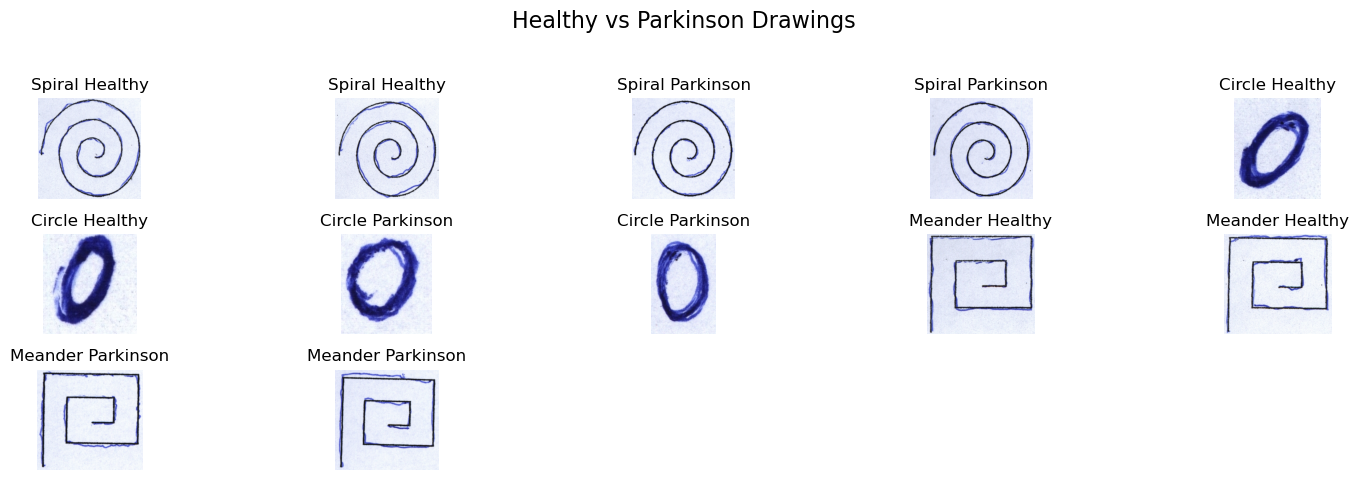

In [3]:

# Labels: 0 = Healthy, 1 = Parkinson
all_labels = (
    [0]*len(spiral_healthy) + [1]*len(spiral_parkinson) +
    [0]*len(circle_healthy) + [1]*len(circle_parkinson) +
    [0]*len(meander_healthy) + [1]*len(meander_parkinson)
)

# Split dataset (example: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Plot example images from dataset (5 examples total)
plt.figure(figsize=(15, 5))

plot_images = [
    (spiral_healthy, "Spiral Healthy"),
    (spiral_parkinson, "Spiral Parkinson"),
    (circle_healthy, "Circle Healthy"),
    (circle_parkinson, "Circle Parkinson"),
    (meander_healthy, "Meander Healthy"),
    (meander_parkinson, "Meander Parkinson"),
]

idx = 1
for images, title in plot_images:
    for i in range(min(2, len(images))):  # Plot max 2 images per class
        plt.subplot(3, 5, idx)
        plt.imshow(images[i])
        plt.title(title)
        plt.axis('off')
        idx += 1

plt.suptitle("Healthy vs Parkinson Drawings", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Assuming label 0 = Healthy, label 1 = Parkinson for each type
# Create image lists and label lists

# Spiral images and labels
spiral_images = spiral_healthy + spiral_parkinson
spiral_labels = [0] * len(spiral_healthy) + [1] * len(spiral_parkinson)

# Circle images and labels
circle_images = circle_healthy + circle_parkinson
circle_labels = [0] * len(circle_healthy) + [1] * len(circle_parkinson)

# Meander images and labels
meander_images = meander_healthy + meander_parkinson
meander_labels = [0] * len(meander_healthy) + [1] * len(meander_parkinson)

# Combine all images and labels
all_images = spiral_images + circle_images + meander_images
all_labels = spiral_labels + circle_labels + meander_labels

print(f"Total images: {len(all_images)}")
print(f"Total labels: {len(all_labels)}")

# Now split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Total images: 594
Total labels: 594
Train set size: 475
Test set size: 119


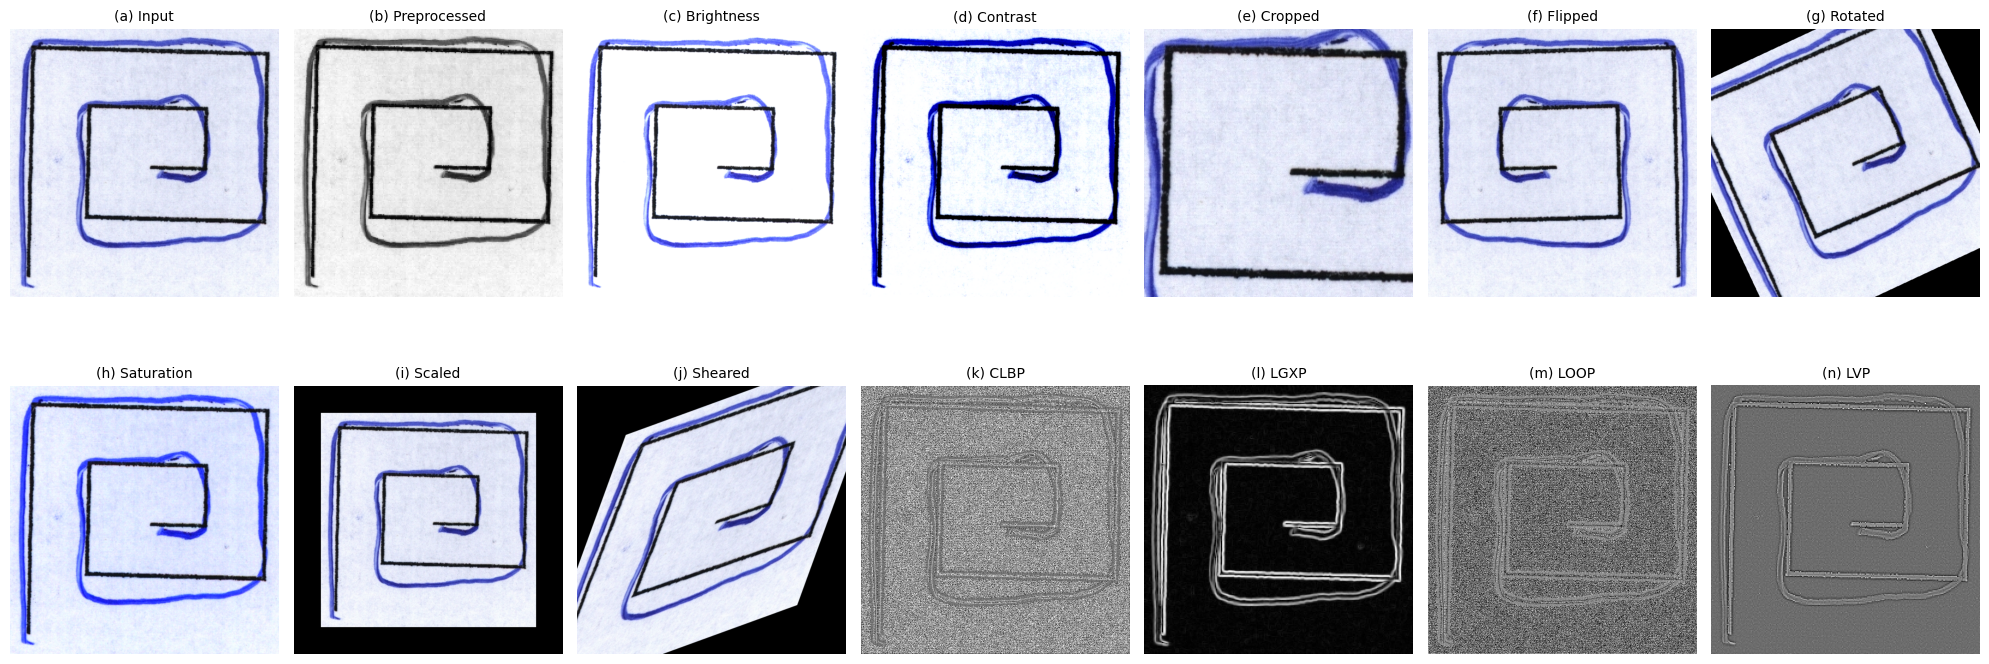

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import albumentations as A
from skimage.feature import local_binary_pattern
from scipy.ndimage import rotate, zoom


sample_img = X_train[0]  


pil_img = Image.fromarray(sample_img)

# 1. Resize and grayscale (preprocessed)
preprocessed_img = cv2.resize(cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY), (224, 224))

# 2. Brightness enhancement
brightness_img = np.array(ImageEnhance.Brightness(pil_img).enhance(1.5))

# 3. Contrast enhancement
contrast_img = np.array(ImageEnhance.Contrast(pil_img).enhance(2.0))

# 4. Center crop (half width & height)
h, w = sample_img.shape[:2]
startx = w // 4
starty = h // 4
cropped_img = sample_img[starty:starty + h // 2, startx:startx + w // 2]

# 5. Horizontal flip
flipped_img = cv2.flip(sample_img, 1)

# 6. Rotation by 25 degrees
rotated_img = rotate(sample_img, angle=25, reshape=False)

# 7. Saturation enhancement
saturation_img = np.array(ImageEnhance.Color(pil_img).enhance(2.0))

# 8. Scaling down by 0.8x and padding back to original size
scaled_img = zoom(sample_img, (0.8, 0.8, 1))
pad_y = (sample_img.shape[0] - scaled_img.shape[0]) // 2
pad_x = (sample_img.shape[1] - scaled_img.shape[1]) // 2
scaled_img = np.pad(scaled_img, ((pad_y, pad_y), (pad_x, pad_x), (0, 0)), mode='constant')

# 9. Shearing using Albumentations
shear_aug = A.Affine(shear=20, p=1.0)
sheared_img = shear_aug(image=sample_img)['image']

# 10. CLBP (Local Binary Pattern)
radius = 1
n_points = 8 * radius
clbp_img = local_binary_pattern(cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY), n_points, radius, method="uniform")

# 11. LGXP (gradient magnitude with Sobel operators)
sobelx = cv2.Sobel(preprocessed_img, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(preprocessed_img, cv2.CV_64F, 0, 1, ksize=3)
lgxp_img = np.hypot(sobelx, sobely)

# 12. LOOP image (255 - CLBP)
loop_img = 255 - clbp_img

# 13. LVP (Laplacian of preprocessed grayscale)
lvp_img = cv2.Laplacian(preprocessed_img, cv2.CV_64F)

# Visualization list and titles
images = [
    sample_img, preprocessed_img, brightness_img, contrast_img, cropped_img, flipped_img,
    rotated_img, saturation_img, scaled_img, sheared_img, clbp_img, lgxp_img, loop_img, lvp_img
]

titles = [
    "(a) Input", "(b) Preprocessed", "(c) Brightness", "(d) Contrast", "(e) Cropped", "(f) Flipped",
    "(g) Rotated", "(h) Saturation", "(i) Scaled", "(j) Sheared", "(k) CLBP", "(l) LGXP", "(m) LOOP", "(n) LVP"
]

# Plotting
fig, axes = plt.subplots(2, 7, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    if images[i].ndim == 2:  # grayscale images
        ax.imshow(images[i], cmap='gray')
    else:  # color images
        ax.imshow(images[i])
    ax.set_title(titles[i], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


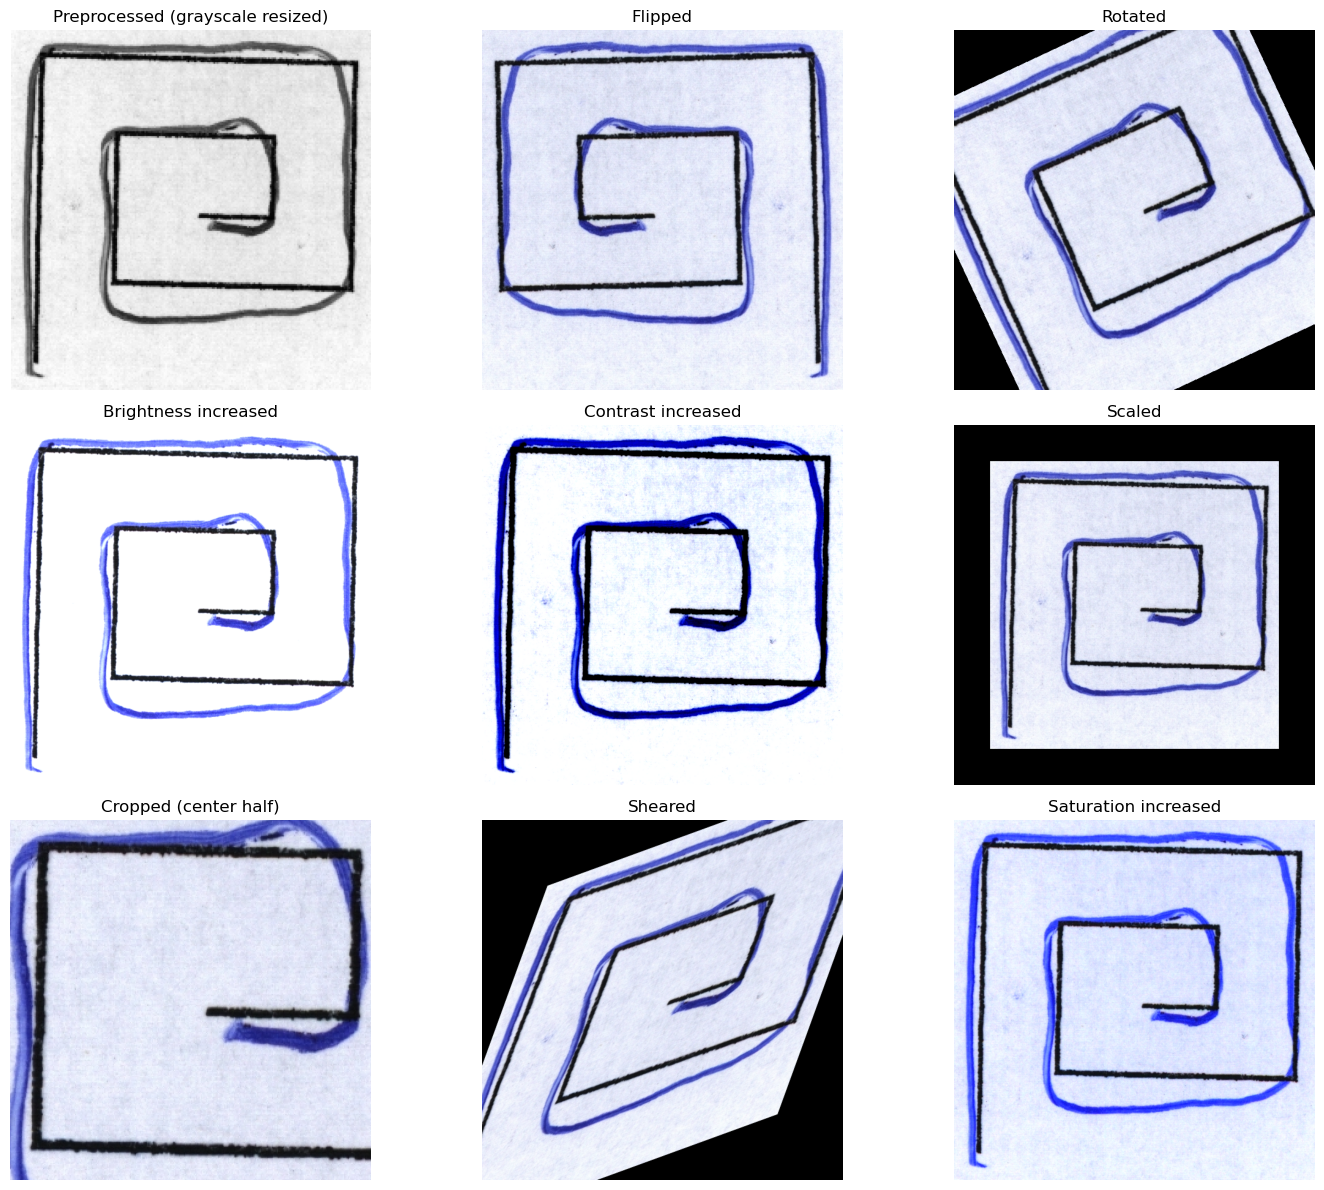

In [6]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import albumentations as A
from scipy.ndimage import rotate, zoom
import matplotlib.pyplot as plt

def augment_image(image):
    """
    image: numpy array RGB (H, W, 3)
    returns: dictionary of augmented images
    """

    pil_img = Image.fromarray(image)

    # Preprocessed image example (resize + grayscale as in your preprocessing)
    FI = cv2.resize(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), (224, 224))

    # Flip (horizontal)
    flipped_img = cv2.flip(image, 1)

    # Rotate by 25 degrees (scipy)
    rotated_img = rotate(image, angle=25, reshape=False).astype(np.uint8)

    # Brightness
    enhancer = ImageEnhance.Brightness(pil_img)
    brightness_img = np.array(enhancer.enhance(1.5))

    # Contrast
    enhancer = ImageEnhance.Contrast(pil_img)
    contrast_img = np.array(enhancer.enhance(2.0))

    # Scaling (zoom 0.8x)
    scaled_img = zoom(image, (0.8, 0.8, 1))
    pad_y = (image.shape[0] - scaled_img.shape[0]) // 2
    pad_x = (image.shape[1] - scaled_img.shape[1]) // 2
    scaled_img = np.pad(scaled_img, ((pad_y, pad_y), (pad_x, pad_x), (0, 0)), mode='constant')

    # Cropping (center crop half size)
    h, w = image.shape[:2]
    startx = w // 4
    starty = h // 4
    cropped_img = image[starty:starty + h // 2, startx:startx + w // 2]

    # Shear augmentation with albumentations
    shear_aug = A.Affine(shear=20, p=1.0)
    sheared_img = shear_aug(image=image)['image']

    # Saturation
    enhancer = ImageEnhance.Color(pil_img)
    saturation_img = np.array(enhancer.enhance(2.0))

    return {
        "Preprocessed (grayscale resized)": FI,
        "Flipped": flipped_img,
        "Rotated": rotated_img,
        "Brightness increased": brightness_img,
        "Contrast increased": contrast_img,
        "Scaled": scaled_img,
        "Cropped (center half)": cropped_img,
        "Sheared": sheared_img,
        "Saturation increased": saturation_img
    }

# Example: use the first training image
sample_img = X_train[0]

augmented_images = augment_image(sample_img)

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (title, img) in enumerate(augmented_images.items()):
    ax = axes[i]
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


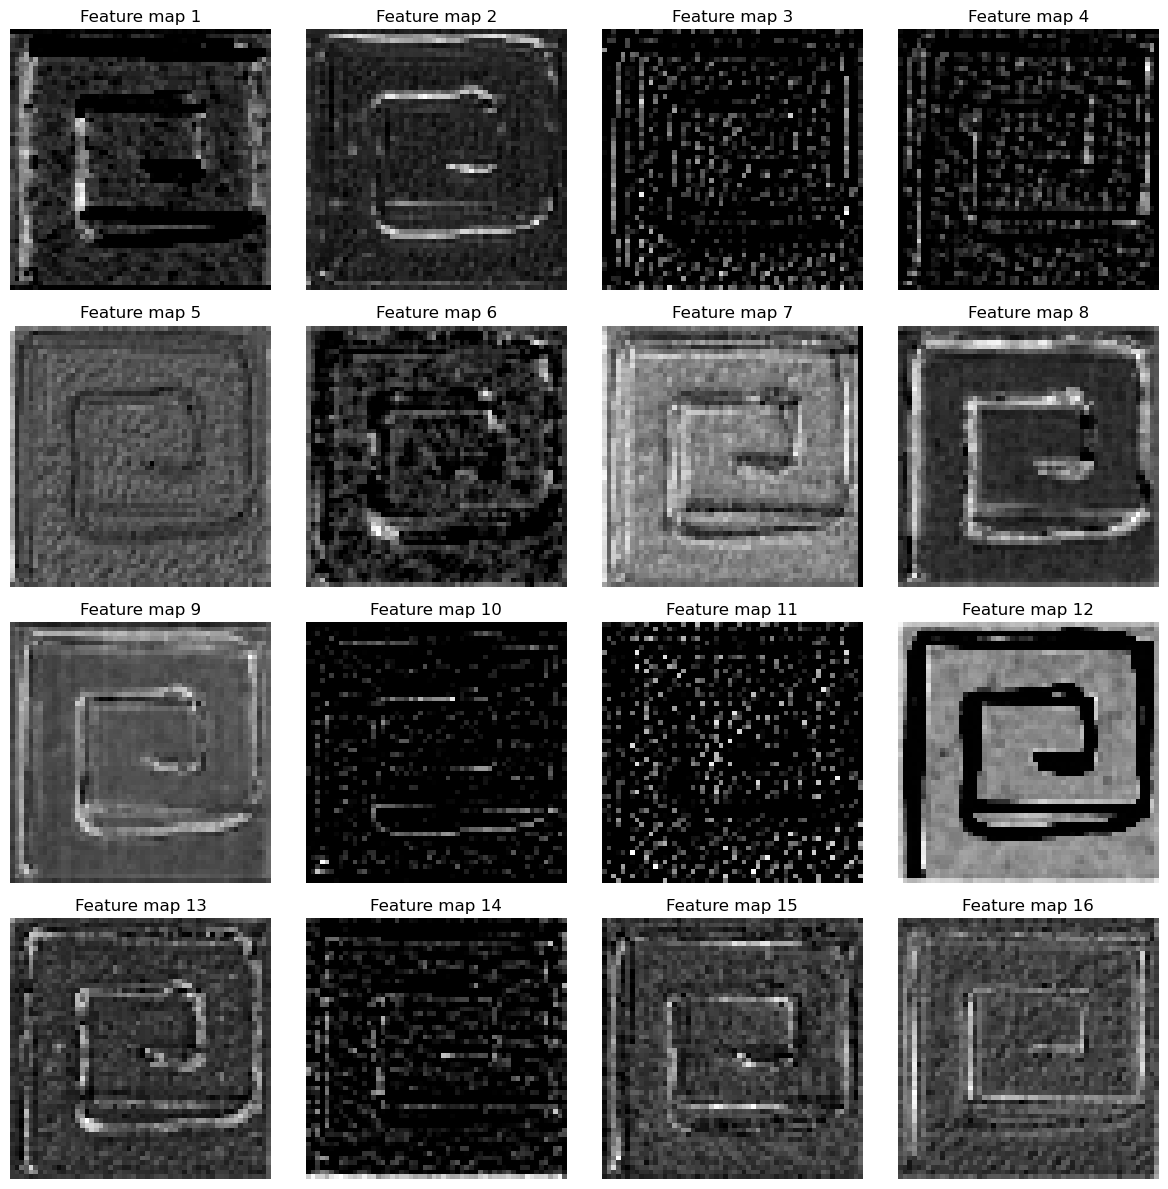

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np


img = X_train[0]  


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]


weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)
resnet.eval()


model_layers = torch.nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1  # output shape: [1, 256, H, W]
)

with torch.no_grad():
    features = model_layers(input_tensor)  # shape: (1, 256, H, W)

feature_maps = features.squeeze(0)  # shape: (256, H, W)

# Visualize first 16 feature maps as grayscale images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flatten()):
    fmap = feature_maps[i].cpu().numpy()
    # Normalize to [0,1] for visualization
    fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-6)
    ax.imshow(fmap, cmap='gray')
    ax.set_title(f'Feature map {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

# ---- Define transforms ----

# Base transform for test images and original train images
base_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Augmentation transform for training images
augmentation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Load ResNet50 model layers for feature extraction ----
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)
resnet.eval()

model_layers = torch.nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool,
    resnet.layer1  # output shape: (1, 256, H, W)
)

# ---- Feature extraction function ----
def extract_feature_vector(img, model_layers, transform):
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model_layers(input_tensor)  # shape: (1, 256, H, W)
    feature_maps = features.squeeze(0)  # Remove batch -> (256, H, W)
    return feature_maps.cpu().numpy().flatten()

# ---- Augmentation + feature extraction for training data ----
def augment_and_extract_features(images, labels, model_layers, base_transform, aug_transform, augment_factor=2):
    all_features = []
    all_labels = []
    for img, label in zip(images, labels):
        # Original image feature
        feat = extract_feature_vector(img, model_layers, base_transform)
        all_features.append(feat)
        all_labels.append(label)

        # Augmented images features
        for _ in range(augment_factor):
            feat_aug = extract_feature_vector(img, model_layers, aug_transform)
            all_features.append(feat_aug)
            all_labels.append(label)

    return np.array(all_features), np.array(all_labels)

# ---- Feature extraction for test data ----
def extract_features_for_test(images, model_layers, base_transform):
    return np.array([extract_feature_vector(img, model_layers, base_transform) for img in images])


X_train_features_aug, y_train_aug = augment_and_extract_features(
    X_train, y_train, model_layers, base_transform, augmentation_transform, augment_factor=3
)

X_test_features = extract_features_for_test(X_test, model_layers, base_transform)

print("Augmented Train Feature Shape:", X_train_features_aug.shape)
print("Test Feature Shape:", X_test_features.shape)


In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import IncrementalPCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import lightgbm as lgb
import matplotlib.pyplot as plt

# Step 1: Variance Threshold
print("Reducing dimensions with VarianceThreshold...")
selector = VarianceThreshold(threshold=0.01)
X_train_reduced = selector.fit_transform(X_train_features_aug)
X_test_reduced = selector.transform(X_test_features)
print("Shape after VarianceThreshold:", X_train_reduced.shape)


In [ ]:
# Step 2: Incremental PCA
print("Reducing further with IncrementalPCA...")
ipca = IncrementalPCA(n_components=100, batch_size=64)  # Tune n_components as needed
X_train_pca = ipca.fit_transform(X_train_reduced)
X_test_pca = ipca.transform(X_test_reduced)
print("Shape after IncrementalPCA:", X_train_pca.shape)

# Step 3: Apply SMOTE
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_pca, y_train_aug)
print("Shape after SMOTE:", X_train_balanced.shape)

In [ ]:
# Step 3: Project again to 100D using SRP
print("Applying Sparse Random Projection...")
srp = SparseRandomProjection(n_components=100, random_state=42)
X_train_proj = srp.fit_transform(X_train_balanced)
X_test_proj = srp.transform(X_test_reduced)


# LightGBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# X_train_proj: 100D projected train features after SMOTE
# X_test_proj:  100D projected test features
# y_train_balanced: labels after SMOTE
# y_test_labels: original test labels

# Step 1: Prepare LightGBM dataset
train_data = lgb.Dataset(X_train_proj, label=y_train_balanced)
test_data = lgb.Dataset(X_test_proj, label=y_test_labels, reference=train_data)

# Step 2: LightGBM parameters
params = {
    'objective': 'multiclass',  # use 'binary' if binary classification
    'num_class': len(np.unique(y_train_balanced)),  # Automatically detect classes
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbosity': -1,
    'random_state': 42
}

# Step 3: Train the model
print("🚀 Training LightGBM...")
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    early_stopping_rounds=10,
    verbose_eval=10  # change to False if you want less output
)

# Step 4: Predict and evaluate
print("📊 Evaluating on test set...")
y_pred = gbm.predict(X_test_proj)
y_pred_labels = np.argmax(y_pred, axis=1)  # for multiclass

print("✅ Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print(classification_report(y_test_labels, y_pred_labels))

# Step 5: Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels)
plt.title("LightGBM Confusion Matrix")
plt.show()


# KNN